In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

In [4]:
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

In [5]:
# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [66]:
train = pd.read_csv('./data/train_v2.csv')
test = pd.read_csv('./data/test_v2.csv')

In [67]:
FEATS_EXCLUDED = ['first_active', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 
                  'new_purchase_date_max', 'new_purchase_date_min']

In [9]:
# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # params optimized by optuna
        params = {'num_leaves': 31,
                 'min_data_in_leaf': 30, 
                 'objective':'regression',
                 'max_depth': -1,
                 'learning_rate': 0.01,
                 "min_child_samples": 20,
                 "boosting": "gbdt",
                 "feature_fraction": 0.9,
                 "bagging_freq": 1,
                 "bagging_fraction": 0.9 ,
                 "bagging_seed": 11,
                 "metric": 'rmse',
                 "lambda_l1": 0.1,
                 "verbosity": -1,
                 "nthread": 4,
                 "random_state": 4590}

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 400,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)

    if not debug:
        # save submission file
        test_df.loc[:,'target'] = sub_preds
        test_df = test_df.reset_index()
        test_df[['card_id', 'target']].to_csv(submission_file_name, index=False)

In [38]:
kfold_lightgbm(train, test, num_folds=3, stratified=False, debug=False)

Starting LightGBM. Train shape: (201917, 299), test shape: (123623, 299)
Training until validation scores don't improve for 400 rounds.
[100]	train's rmse: 3.60094	test's rmse: 3.7994
[200]	train's rmse: 3.50731	test's rmse: 3.7703
[300]	train's rmse: 3.44714	test's rmse: 3.75853
[400]	train's rmse: 3.3996	test's rmse: 3.75181
[500]	train's rmse: 3.36054	test's rmse: 3.74807
[600]	train's rmse: 3.32796	test's rmse: 3.74565
[700]	train's rmse: 3.29902	test's rmse: 3.74364
[800]	train's rmse: 3.27214	test's rmse: 3.74313
[900]	train's rmse: 3.24768	test's rmse: 3.74207
[1000]	train's rmse: 3.2225	test's rmse: 3.74154
[1100]	train's rmse: 3.20039	test's rmse: 3.74107
[1200]	train's rmse: 3.17952	test's rmse: 3.74128
[1300]	train's rmse: 3.15931	test's rmse: 3.74127
[1400]	train's rmse: 3.13907	test's rmse: 3.74139


KeyboardInterrupt: 

In [69]:
def target(data):
    if data < 0:
        return -1 * (np.abs(data) ** 2)
    else:
        return np.abs(data) ** 2

In [70]:
train.target = train.target.apply(target)

In [72]:
train.target.describe()

count    201917.000000
mean        -12.160071
std         115.005296
min       -1103.520627
25%          -0.779884
50%          -0.000549
75%           0.585918
max         322.743683
Name: target, dtype: float64

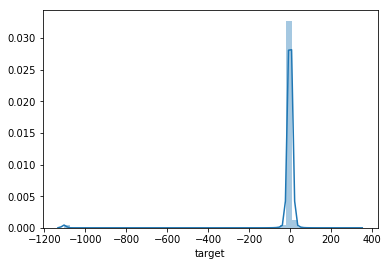

In [73]:
sns.distplot(train.target)

In [74]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

oof_lgb_3 = np.zeros(len(train))
predictions_lgb_3 = np.zeros(len(test))
start = time.time()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

train_columns = [f for f in train.columns if f not in FEATS_EXCLUDED]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=train.iloc[trn_idx]['target'])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=train.iloc[val_idx]['target'])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb_3[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb_3 += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.save('oof_lgb_3', oof_lgb_3)
np.save('predictions_lgb_3', predictions_lgb_3)
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb_3, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 108.58	valid_1's rmse: 111.143
[200]	training's rmse: 105.49	valid_1's rmse: 110.292
[300]	training's rmse: 103.451	valid_1's rmse: 110.066
[400]	training's rmse: 102.017	valid_1's rmse: 110.026
[500]	training's rmse: 100.907	valid_1's rmse: 110.021
[600]	training's rmse: 99.9883	valid_1's rmse: 110.015
[700]	training's rmse: 99.1888	valid_1's rmse: 110.03
Early stopping, best iteration is:
[580]	training's rmse: 100.151	valid_1's rmse: 110.011
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 108.498	valid_1's rmse: 111.515
[200]	training's rmse: 105.404	valid_1's rmse: 110.664
[300]	training's rmse: 103.281	valid_1's rmse: 110.373
[400]	training's rmse: 101.801	valid_1's rmse: 110.263
[500]	training's rmse: 100.715	valid_1's rmse: 110.219
[600]	training's rmse: 99.7984	valid_1's rmse: 110.19
[700]	training's rmse: 99.019	valid_1's rmse: 110.176
[

TypeError: Expected sequence or array-like, got <class 'function'>

In [76]:
sub.target = predictions_lgb_3

In [77]:
def target(data):
    if data < 0:
        return -1 * np.sqrt(np.abs(data))
    else:
        return np.sqrt(np.abs(data))

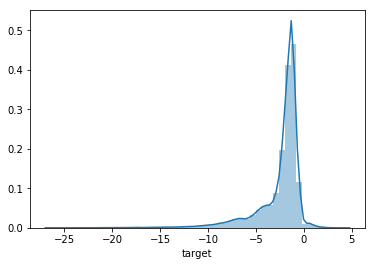

In [78]:
sns.distplot(sub.target.apply(target))

In [80]:
sub.target = sub.target.apply(target)

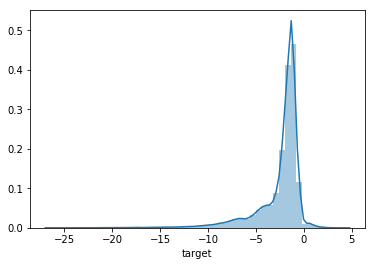

In [82]:
sns.distplot(sub.target)

In [83]:
sub.set_index('card_id').to_csv('./data/submission_exp.csv')

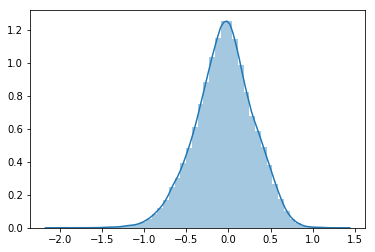

In [31]:
sns.distplot(predictions_lgb_3)

fold n°0
[1273]	training's rmse: 3.25506	valid_1's rmse: 3.65738


fold n°1
[1384]	training's rmse: 3.22969	valid_1's rmse: 3.66306


fold n°2
[1232]	training's rmse: 3.26398	valid_1's rmse: 3.64099


fold n°3
[1215]	training's rmse: 3.27165	valid_1's rmse: 3.64481


fold n°4
[2077]	training's rmse: 3.12981	valid_1's rmse: 3.65253

In [74]:
predictions_lgb_3[predictions_lgb_3 > 2]

array([2.32999229, 2.53781853, 2.06693843, 2.48161171, 2.84142491,
       2.48843846, 2.14476513, 2.03352887, 2.11725778, 2.55760807,
       2.07781317, 2.28787291, 2.1069452 , 2.30426006, 2.10866183,
       2.05738294, 2.1506543 , 2.16892991, 2.14186269, 2.29499346,
       2.75384496, 2.0211568 , 2.42814908, 2.02904408, 2.15894229,
       2.0919519 , 2.09319541, 2.16863452, 2.07527648, 2.23914524,
       2.11450346, 2.55101599, 2.29091062, 2.20958865, 2.34168952,
       2.09183033, 2.96276736, 2.0626897 , 3.00684215, 2.35126234,
       2.17190077, 2.00497626])

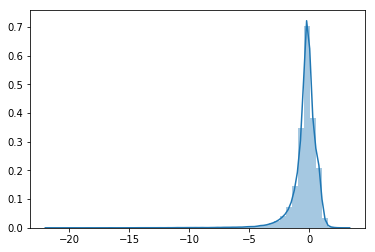

In [69]:
sns.distplot(predictions_lgb_3)

In [35]:
sub = pd.read_csv('./data/sample_submission.csv')

In [76]:
sub2.target = predictions_lgb_3

In [77]:
sub2.set_index('card_id').to_csv('./data/submission2.csv')

In [84]:
t = np.abs(train.target)

In [108]:
len(t[t < 6]) / len(t)

0.9810763828701893

In [97]:
sub[sub.target > 4]

,card_id,target
13239,C_ID_a33c9a5e8c,4.839309
21801,C_ID_fc32359498,4.125391
25581,C_ID_69498b273d,4.000393
43166,C_ID_b5d26a049b,4.130488
59209,C_ID_0a1852e511,4.362346
59252,C_ID_bca195ea95,4.017605
92896,C_ID_c0fa95edda,4.429211
102755,C_ID_785bd55fd9,4.888917


In [111]:
sub['target2'] = sub2.target

In [147]:
def target(v):
    if v.target >= 3:
        return v.target
    else:
        return v.target2

In [121]:
sub3 = pd.read_csv('./data/sample_submission.csv')

In [148]:
sub3 = sub.set_index('card_id').apply(target, axis = 1).to_frame()

In [154]:
sub3.to_csv('./data/submission3.csv')

In [155]:
sub3[sub3]

,0
card_id,
C_ID_0ab67a22ab,-2.897076
C_ID_130fd0cbdd,-0.432534
C_ID_b709037bc5,-1.058020
C_ID_d27d835a9f,-0.158324
C_ID_2b5e3df5c2,-1.497674
C_ID_5814b4f13c,0.053009
C_ID_a1b3c75277,-0.013663
C_ID_f7cada36d3,0.452156
C_ID_9d2bc8dfc4,-0.728732


In [153]:
sub3[sub3[0] > 3]

,0
card_id,
C_ID_c26381a58e,3.163743
C_ID_ba200f330e,3.187992
C_ID_96dad115f9,3.017191
C_ID_0d8283ac57,3.232457
C_ID_f616eab6f6,3.067315
C_ID_a33c9a5e8c,4.839309
C_ID_cf6d963e36,3.780871
C_ID_55e58ed34e,3.730379
C_ID_047cc5495b,3.523931


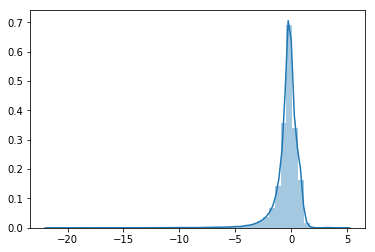

In [138]:
sns.distplot(sub3)

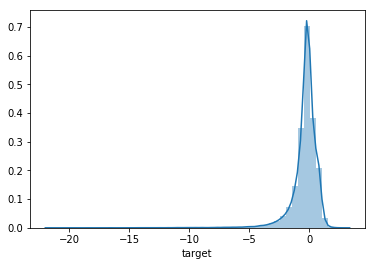

In [140]:
sns.distplot(sub2.target)

In [128]:
sub3.to_csv('./data/submission3.csv')

In [109]:
sub2[sub2.target < -6].shape

(865, 2)

In [135]:
sub

,card_id,target,target2
0,C_ID_0ab67a22ab,-0.554003,-2.897076
1,C_ID_130fd0cbdd,-0.207404,-0.432534
2,C_ID_b709037bc5,-0.301900,-1.058020
3,C_ID_d27d835a9f,-0.121866,-0.158324
4,C_ID_2b5e3df5c2,-1.374038,-1.497674
5,C_ID_5814b4f13c,0.841239,0.053009
6,C_ID_a1b3c75277,0.186869,-0.013663
7,C_ID_f7cada36d3,0.905937,0.452156
8,C_ID_9d2bc8dfc4,-0.743031,-0.728732
9,C_ID_6d8dba8475,-0.224681,-0.808007


In [134]:
sub2[sub2.target >3]

,card_id,target
102755,C_ID_785bd55fd9,3.006842


In [133]:
sub[sub.target > 3]

,card_id,target,target2
142,C_ID_c26381a58e,3.163743,1.707343
2805,C_ID_ba200f330e,3.187992,-0.798100
7034,C_ID_96dad115f9,3.017191,1.771901
8495,C_ID_0d8283ac57,3.232457,1.774985
9995,C_ID_f616eab6f6,3.067315,1.807544
13239,C_ID_a33c9a5e8c,4.839309,2.537819
15797,C_ID_cf6d963e36,3.780871,2.481612
17040,C_ID_55e58ed34e,3.730379,2.841425
19166,C_ID_047cc5495b,3.523931,1.762883
19245,C_ID_a88b736e3b,3.368825,1.979235


In [157]:
train.head(3)

,card_id,feature_1,feature_2,feature_3,first_active_month,outliers,target,first_active,first_active_year,first_active_quarter,first_active_weekofyear,first_active_dayofweek,first_active_elapsed_time_from_trade,first_active_elapsed_time_from_today,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,hist_authorized_flag_mode,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_card_id_size,hist_city_id_mode,hist_city_id_nunique,hist_category_1_mode,hist_category_1_sum,hist_category_1_mean,hist_installments_mode,hist_installments_sum,hist_installments_mean,hist_installments_var,hist_installments_max,hist_installments_min,hist_installments_null_cnt,hist_category_3_mode,hist_category_3_mean,hist_merchant_category_id_mode,hist_merchant_category_id_nunique,hist_merchant_id_nunique,hist_month_lag_mode,hist_month_lag_sum,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_max,hist_month_lag_min,hist_month_lag_skew,hist_purchase_date_max,hist_purchase_date_min,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_skew,hist_purchase_amount_over_550,hist_category_2_mode,hist_category_2_mean,hist_state_id_mode,hist_state_id_nunique,hist_subsector_id_mode,hist_subsector_id_nunique,hist_purchase_amount_trim_sum,hist_purchase_amount_trim_mean,hist_purchase_amount_trim_var,hist_purchase_amount_trim_max,hist_purchase_amount_trim_min,hist_purchase_amount_trim_skew,hist_purchase_year_mode,hist_purchase_year_nunique,hist_purchase_year_mean,hist_purchase_year_max,hist_purchase_year_min,hist_purchase_month_mode,hist_purchase_month_nunique,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_day_mode,hist_purchase_day_nunique,hist_purchase_day_mean,hist_purchase_day_var,hist_purchase_day_max,hist_purchase_day_min,hist_purchase_day_skew,hist_purchase_hour_mode,hist_purchase_hour_nunique,hist_purchase_hour_mean,hist_purchase_hour_var,hist_purchase_hour_max,hist_purchase_hour_min,hist_purchase_hour_skew,hist_purchase_dayofweek_mode,hist_purchase_dayofweek_nunique,hist_purchase_dayofweek_mean,hist_purchase_dayofweek_max,hist_purchase_dayofweek_min,hist_purchase_weekofyear_mode,hist_purchase_weekofyear_nunique,hist_purchase_weekofyear_mean,hist_purchase_weekofyear_max,hist_purchase_weekofyear_min,hist_purchase_weekend_mode,hist_purchase_weekend_sum,hist_purchase_weekend_mean,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_Christmas_Day_2017_mean,hist_Mothers_Day_2017_mean,hist_fathers_day_2017_mean,hist_Children_day_2017_mean,hist_Valentine_Day_2017_mean,hist_Black_Friday_2017_mean,hist_Mothers_Day_2018_mean,hist_duration_mean,hist_duration_min,hist_duration_max,hist_duration_var,hist_duration_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_var,hist_amount_month_ratio_skew,hist_category_2_mean_mean,hist_category_2_min_mean,hist_category_2_max_mean,hist_category_2_sum_mean,hist_category_3_mean_mean,hist_category_3_min_mean,hist_category_3_max_mean,hist_category_3_sum_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin,new_authorized_flag_mode,new_authorized_flag_sum,new_authorized_flag_mean,new_card_id_size,new_city_id_mode,new_city_id_nunique,new_category_1_mode,new_category_1_sum,new_category_1_mean,new_installments_mode,new_installments_sum,new_installments_mean,new_installments_var,new_installments_max,new_installments_min,new_installments_null_cnt,new_category_3_mode,new_category_3_mean,new_merchant_category_id_mode,new_merchant_category_id_nunique,new_merchant_id_nunique,new_month_lag_mode,new_month_lag_sum,new_month_lag_mean,new_month_lag_var,new_month_lag_